## ISOMAP Introduction

The goal of ISOMAP is to produce a low dimensional representation of the data that preserves the ‘walking distance’ of the cloud data (manifold). 

1. Create adjacency matrix of local Euclidean distances: Find neighbors $N(i)$ of each data point, $𝑥^i$, within distance 𝜖 and let the adjacency matrix, A, recording neighbor Euclidean distance.

2. Create shortest path pairwise matrix: Matrix D between each pair of points, $𝑥^𝑖$,$𝑥^𝑗$ based on A.

3. Reduce dimensional representation: Find a low dimensional representation that preserves the distances in D


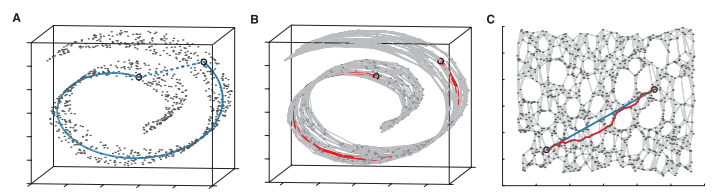

ISOMAP is just one example of non-linear dimensional reduction. Other non-linear techniques include local-linear embedding, kernel based methods such as kPCA, manifold learning, and t-SNE. Many of these methods are accessable directly through libraries such as {scikit-learn}. 

This analysis will break down the ISOMAP Algorithm into individual coded steps.

**ISOMAP algorithm:** Tenenbaum, J. B., de Silva, V. & Langford, J. C. (2000). A Global Geometric Framework for Nonlinear Dimensionality Reduction. Science, 290, 2319.


## Why not PCA or SVD?

PCA or SVD are suitable when variables are linearly correlated, as they use linear projection $~w^T (x^i−μ)$, implicitly assuming Euclidean distance is the dissimilarity (distance) measure.

When there is a nonlinear structure, Euclidean distance is not the right distance measure **globally**. Locally, Euclidean distance is okay!

## ISOMAP Algorithm


1. Identify local neighbors using a weighted nearest neighbor graph
    - ϵ-ISOMAP: Build connections if the distance is closer than epslion. 
    - K-ISOMAP: Select k nearest neighbors (better for sparse data)
    
2. Compute pairwise shortest distance matrix D
    - Floyd-Warshall algorithm
    - Dijkstra's algorithm
    
3. Compute The centering matrix, H, via MDS (Multi-dimensional scaling). Essentially, given Euclidean distances, compute the resulting coordinates.

4. Reduce dimensionality of D through eigen decomposition

## Libraries

In [1]:
# Import Libraries
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
import scipy.sparse.linalg as ll

## Load and prep data

In [2]:
# load mat file
data_isomap = sio.loadmat('data/isomap.mat', squeeze_me=True)

# set up array of images
images = data_isomap['images'].T
n,m = images.shape
print(f'n:{n}, m:{m}, type: {type(images)}')

n:698, m:4096, type: <class 'numpy.ndarray'>


## Nearest neighbor graph, A


**Notes on tuning 𝜖**

Epsilon was tuned using + 0.1 increments until the pairwise shortest path matrix, D, held no infinite values. I compared this to the k-nearest neighbor graphs of recommended size 𝑘=5 (ISOMAP default). Since the selected setting 𝜖≥10.5, was much denser than the default k-nearest neighbor graph, I selected the minimum value that fully populated the D matrix. The goal was to avoid ‘short-circuit’ errors when k or epsilon are too large, or errors that result when the matrix is too sparse when k is too small.

You may find it easier to use {kneighbors_graph} with the recommended ISOMAP neighbors of 8<=k<=12 per M. Balasubramanian, E. L. Schwartz, The Isomap Algorithm and Topological Stability. Science 4 January 2002: Vol. 295 no. 5552 p. 7.

A: (698, 698)


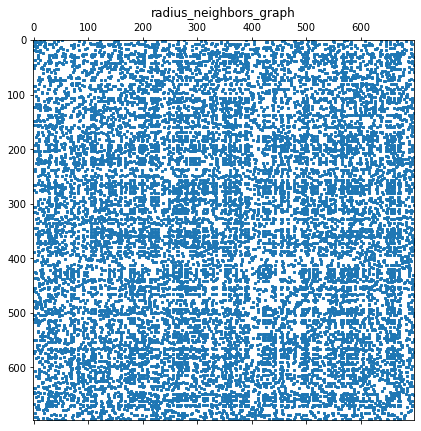

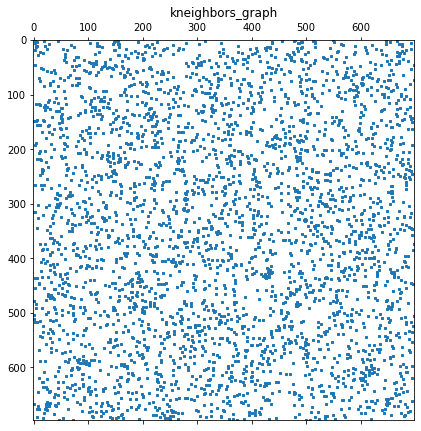

In [49]:
# set epsilon or k
# 10.5 min, or else there are some non-connections and the code will break! 
# Note this is much more dense that the recommended ISOMAP neighbor setting
epsilon = 10.5 
neighbors = 5

# create nearest neighbor graph
A = radius_neighbors_graph(
    X = images, 
    radius = epsilon,
    mode='distance',
    metric='minkowski',
    p=2,
    include_self=True,
    n_jobs = -1)

print(f'A: {A.shape}')

# alternative, using recommendation for n_neighbors for ISOMAP
A_knn = kneighbors_graph(
    X = images, 
    n_neighbors = neighbors,
    mode='distance',
    metric='minkowski',
    p=2, 
    include_self=False,
    n_jobs = -1)

# plot
plt.figure(figsize=(7, 7))
plt.title("radius_neighbors_graph")
plt.spy(A,markersize=2)
plt.show()

# plot
plt.figure(figsize=(7, 7))
plt.title("kneighbors_graph")
plt.spy(A_knn,markersize=2)
plt.show()

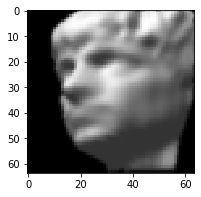

In [50]:
# plot distances
# print(A)
# (697, 374) 2.27
# (0, 149) 5.58
# (0, 574) 10.15

# plot a figure
plt.figure(figsize = (3,3))
img = images[574, :].reshape(64, 64).T
plt.imshow(img, aspect='auto', interpolation='nearest',cmap=plt.cm.gray,zorder=1)


## Shortest path gaph, D

In [4]:
D = shortest_path(
    csgraph= A,
    method = 'FW',
    directed=False)

print(f'D: {D.shape}, type: {type(D)}')

# count infinites...
print(f'Number of inf cases: {np.sum(D ==np.inf)}')

D: (698, 698), type: <class 'numpy.ndarray'>
Number of inf cases: 0


## Eigen decomposition

In [5]:
# create centering matrix
I = np.identity(n)
ones = np.ones((n, n))
H = I - (1 / n)*(ones)

# calc D^2 matrix
D_sq = D**2

# G matrix
G = (-1 /2) * (H.dot(D_sq).dot(H))

# get eigens
S,W = ll.eigs(G,k = 2)
S = S.real #eigenvalues
W = W.real #eigenvectors

# dim1 and dim2
dim1 = W[:,0] * math.sqrt(S[0])
dim2 = W[:,1] * math.sqrt(S[1])

## Plot

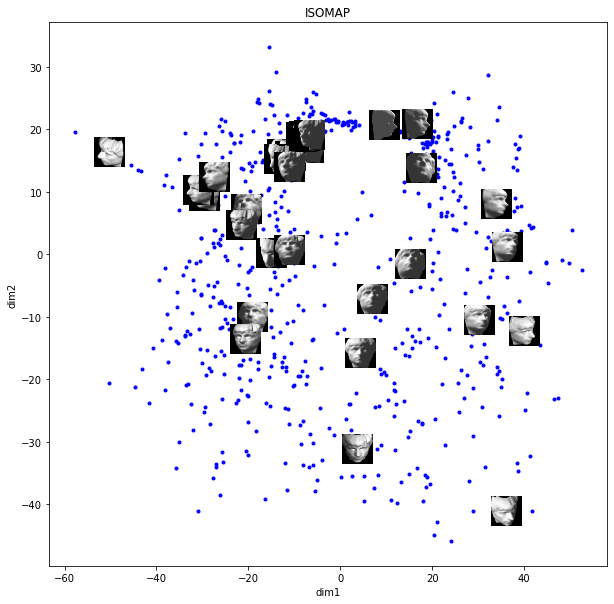

In [6]:
figure = plt.figure()
figure.set_size_inches(10, 10)
ax1 = figure.add_subplot(111)

# title and axis labels
ax1.set_title("ISOMAP")
ax1.set_xlabel('dim1')
ax1.set_ylabel('dim2')

# axis ranges
x_size = (max(dim1) - min(dim1)) * 0.06
y_size = (max(dim2) - min(dim2)) * 0.06

# add 30 random images
for i in range(30):
    # get random photo
    img_num = np.random.randint(0, n)
    # starting and ending x, y for image
    x0 = dim1[img_num] - (x_size / 2.)
    y0 = dim2[img_num] - (y_size / 2.)
    x1 = dim1[img_num] + (x_size / 2.)
    y1 = dim2[img_num] + (y_size / 2.)
    img = images[img_num, :].reshape(64, 64).T
    ax1.imshow(img, aspect='auto', interpolation='nearest',cmap=plt.cm.gray, zorder=1, extent=(x0, x1, y0, y1))

# add dots
ax1.scatter(dim1, dim2, marker='.',c='blue', alpha=1)

# show
plt.show()

In [7]:
# load mat file
data_isomap = sio.loadmat('data/isomap.mat', squeeze_me=True)

# set up array of images
images = data_isomap['images'].T
n,m = images.shape
print(f'n:{n}, m:{m}, type: {type(images)}')

n:698, m:4096, type: <class 'numpy.ndarray'>


## PCA

In [8]:
%reset -f


In [9]:
# Import Libraries
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
import scipy.sparse.linalg as ll

In [10]:
# load mat file
data_isomap = sio.loadmat('data/isomap.mat', squeeze_me=True)

# set up array of images
images = data_isomap['images'].T
n,m = images.shape
print(f'n:{n}, m:{m}, type: {type(images)}')

n:698, m:4096, type: <class 'numpy.ndarray'>


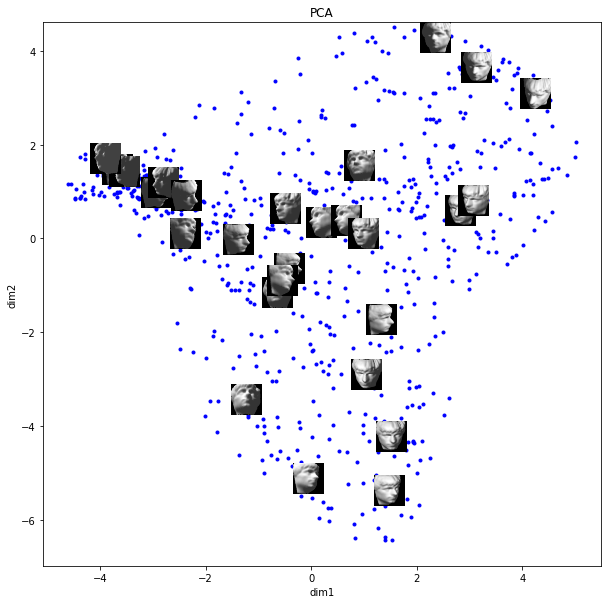

In [11]:
Anew = images.T

mu = np.mean(Anew,axis = 1)
xc = Anew - mu[:,None]

C = np.dot(xc,xc.T)/m

S,W = ll.eigs(C,k = 2)
S = S.real
W = W.real

dim1 = np.dot(W[:,0].T,xc)/math.sqrt(S[0]) # extract 1st eigenvalues
dim2 = np.dot(W[:,1].T,xc)/math.sqrt(S[1]) # extract 2nd eigenvalue

figure2 = plt.figure()
figure2.set_size_inches(10, 10)
ax2 = figure2.add_subplot(111)

# title and axis labels
ax2.set_title("PCA")
ax2.set_xlabel('dim1')
ax2.set_ylabel('dim2')

# axis ranges
x_size = (max(dim1) - min(dim1)) * 0.06
y_size = (max(dim2) - min(dim2)) * 0.06

# add 30 random images
for i in range(30):
    # get random photo
    img_num = np.random.randint(0, n)
    # starting and ending x, y for image
    x0 = dim1[img_num] - (x_size / 2.)
    y0 = dim2[img_num] - (y_size / 2.)
    x1 = dim1[img_num] + (x_size / 2.)
    y1 = dim2[img_num] + (y_size / 2.)
    img = images[img_num, :].reshape(64, 64).T
    ax2.imshow(img, aspect='auto', interpolation='nearest',cmap=plt.cm.gray, zorder=1, extent=(x0, x1, y0, y1))

# add dots
ax2.scatter(dim1, dim2, marker='.',c='blue', alpha=1)

# show
plt.show()

## Results

ISOMAP organizes the images in a more meaningful way than PCA. For example, clusters of like images are facing to the same direction from left to right, and top to bottom. The amount of rotation is also captured along the 2 dimensions. Dim 2 seems to capture up-down pose and dim 1 capture left-right pose.

In PCA, images are organized in a less meaningful way than ISOMAP. It seems that dim 1 captures darker-to-lighter changes while dim2 captures light vs. dark for the right-to-left side of the image.